#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature 가 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 로컬 수행(Ananconda)
        * 제공된 압축파일을 다운받아 압축을 풀고
        * anaconda의 root directory(보통 C:/Users/< ID > 에 project3_1 폴더를 만들고, 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 라이브러리 로딩

* 라이브러리 로딩

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [166]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [170]:
data = pd.read_csv('data01_train.csv')

In [171]:
data

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,21,SITTING
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,15,WALKING_UPSTAIRS
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,19,LAYING
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,6,WALKING_UPSTAIRS


In [172]:
data = data.drop('subject', axis=1)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [179]:
data.shape

(5881, 562)

In [180]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [183]:
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

In [184]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [189]:
# 'Activity' 별로 그룹화하여 통계량을 계산
activity_analysis = data.groupby('Activity').agg(['mean', 'std', 'min', 'max'])
activity_analysis

tBodyAcc-mean()-X                                \
                                mean       std       min       max   
Activity                                                             
LAYING                      0.271483  0.091746 -0.503823  1.000000   
SITTING                     0.272837  0.043774 -0.412659  0.559135   
STANDING                    0.278693  0.017002  0.111231  0.436123   
WALKING                     0.275589  0.049775  0.121465  0.419881   
WALKING_DOWNSTAIRS          0.290086  0.094827 -0.161088  0.617597   
WALKING_UPSTAIRS            0.261603  0.078441 -0.029595  0.480180   

                   tBodyAcc-mean()-Y                                \
                                mean       std       min       max   
Activity                                                             
LAYING                     -0.018417  0.070753 -0.684893  1.000000   
SITTING                    -0.012072  0.031209 -0.121073  0.324130   
STANDING                   -0.016679  0.015362 -0.116007  0.102541   
WALKING                    -0.017413  0.020797 -0.127407  0.071488   
WALKING_DOWNSTAIRS         -0.016740  0.027274 -0.094826  0.099755   
WALKING_UPSTAIRS           -0.026729  0.037058 -0.183885  0.100904   

                   tBodyAcc-mean()-Z            ... angle(X,gravityMean)  \
                                mean       std  ...                  min   
Activity                                        ...                        
LAYING                     -0.107785  0.096247  ...             0.248828   
SITTING                    -0.106352  0.044441  ...            -0.987260   
STANDING                   -0.107184  0.036562  ...            -0.998909   
WALKING                    -0.109834  0.033010  ...            -0.967689   
WALKING_DOWNSTAIRS         -0.105793  0.049777  ...            -1.000000   
WALKING_UPSTAIRS           -0.120764  0.059608  ...            -0.876955   

                             angle(Y,gravityMean)                      \
                         max                 mean       std       min   
Activity                                                                
LAYING              0.977344            -0.442074  0.288333 -1.000000   
SITTING             0.112294            -0.005482  0.133725 -0.369205   
STANDING           -0.450563             0.210669  0.067796  0.010798   
WALKING            -0.446261             0.219866  0.057455  0.013633   
WALKING_DOWNSTAIRS -0.460887             0.197577  0.062579  0.009416   
WALKING_UPSTAIRS   -0.246872             0.282750  0.070129 -0.053805   

                             angle(Z,gravityMean)                      \
                         max                 mean       std       min   
Activity                                                                
LAYING              0.478157            -0.442538  0.353233 -0.980143   
SITTING             0.300349            -0.096410  0.162416 -0.526474   
STANDING            0.372796             0.043542  0.112761 -0.233938   
WALKING             0.351155             0.067278  0.113249 -0.221381   
WALKING_DOWNSTAIRS  0.369196             0.057130  0.116191 -0.223708   
WALKING_UPSTAIRS    0.405863             0.130762  0.146070 -0.178316   

                              
                         max  
Activity                      
LAYING              1.000000  
SITTING             0.329659  
STANDING            0.369187  
WALKING             0.362180  
WALKING_DOWNSTAIRS  0.344564  
WALKING_UPSTAIRS    0.488889  

[6 rows x 2244 columns]

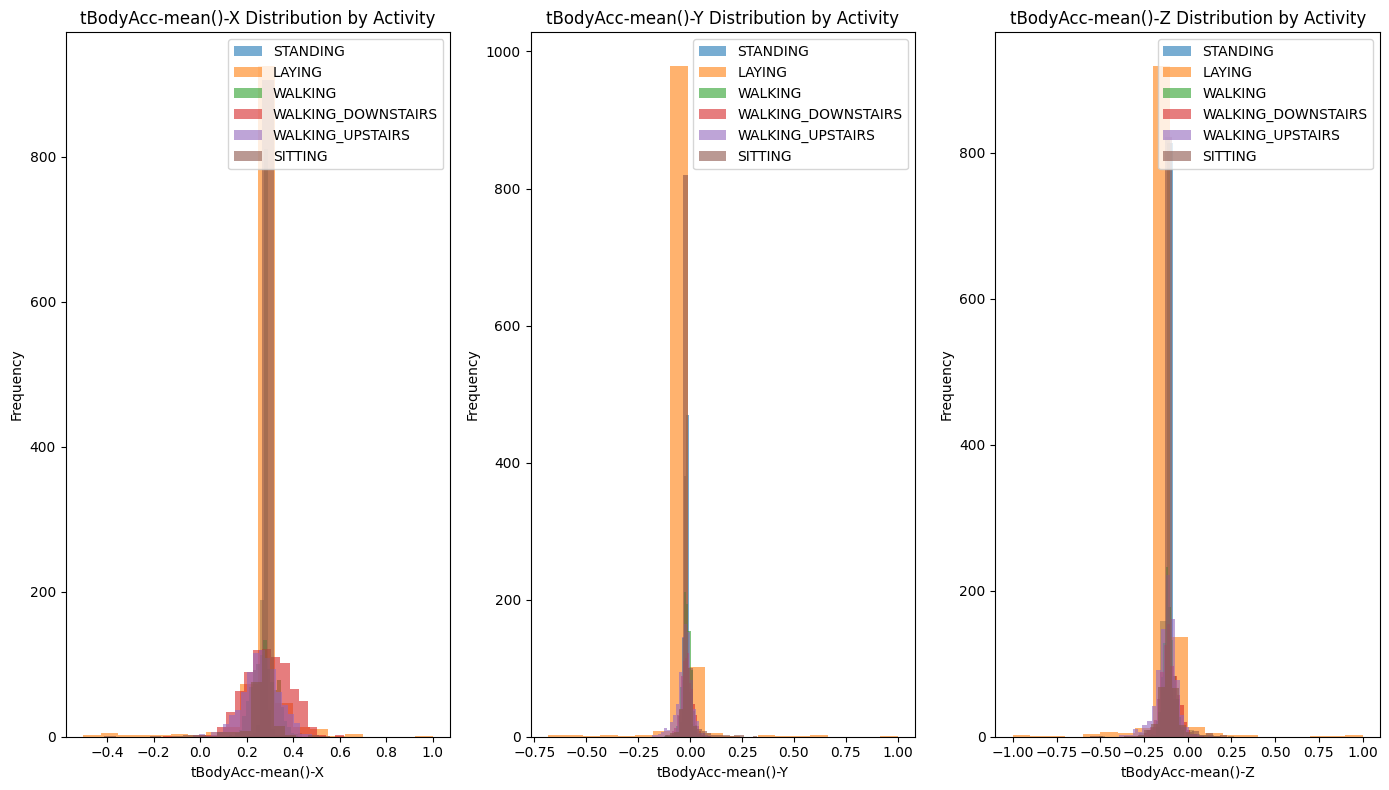

In [190]:
# 히스토그램으로 'tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z' 분포를 시각화
plt.figure(figsize=(14, 8))

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(1, 3, i)
    for activity in data['Activity'].unique():
        subset = data[data['Activity'] == activity]
        plt.hist(subset[col], bins=20, alpha=0.6, label=activity)
    plt.title(f'{col} Distribution by Activity')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    
plt.tight_layout()
plt.show()

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [195]:
# Target = 'Activity'
target = 'Activity'

# x, y 분할
x = data.drop(columns=target)
y = data.loc[:, target]

# train, validation 분할
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

In [197]:
# 분할 확인
print(x_train.shape)
print(x_val.shape)

(4116, 562)
(1765, 562)


#### 2) 모델링

In [200]:
# Random Forest 모델을 하이퍼파라미터의 기본값으로 생성 및 학습
model_rf = RandomForestClassifier(random_state=1)
model_rf.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

#### 3) 변수 중요도 추출

,feature_name,feature_importance
0,"angle(Y,gravityMean)",0.032465
1,tGravityAcc-max()-X,0.027618
2,tGravityAcc-max()-Y,0.027586
3,tGravityAcc-energy()-X,0.025960
4,tGravityAcc-mean()-X,0.023899
5,"angle(X,gravityMean)",0.023188
6,tGravityAcc-min()-Y,0.023081
7,tGravityAcc-mean()-Y,0.021552
8,tGravityAcc-min()-X,0.021029
9,tGravityAcc-energy()-Y,0.019922


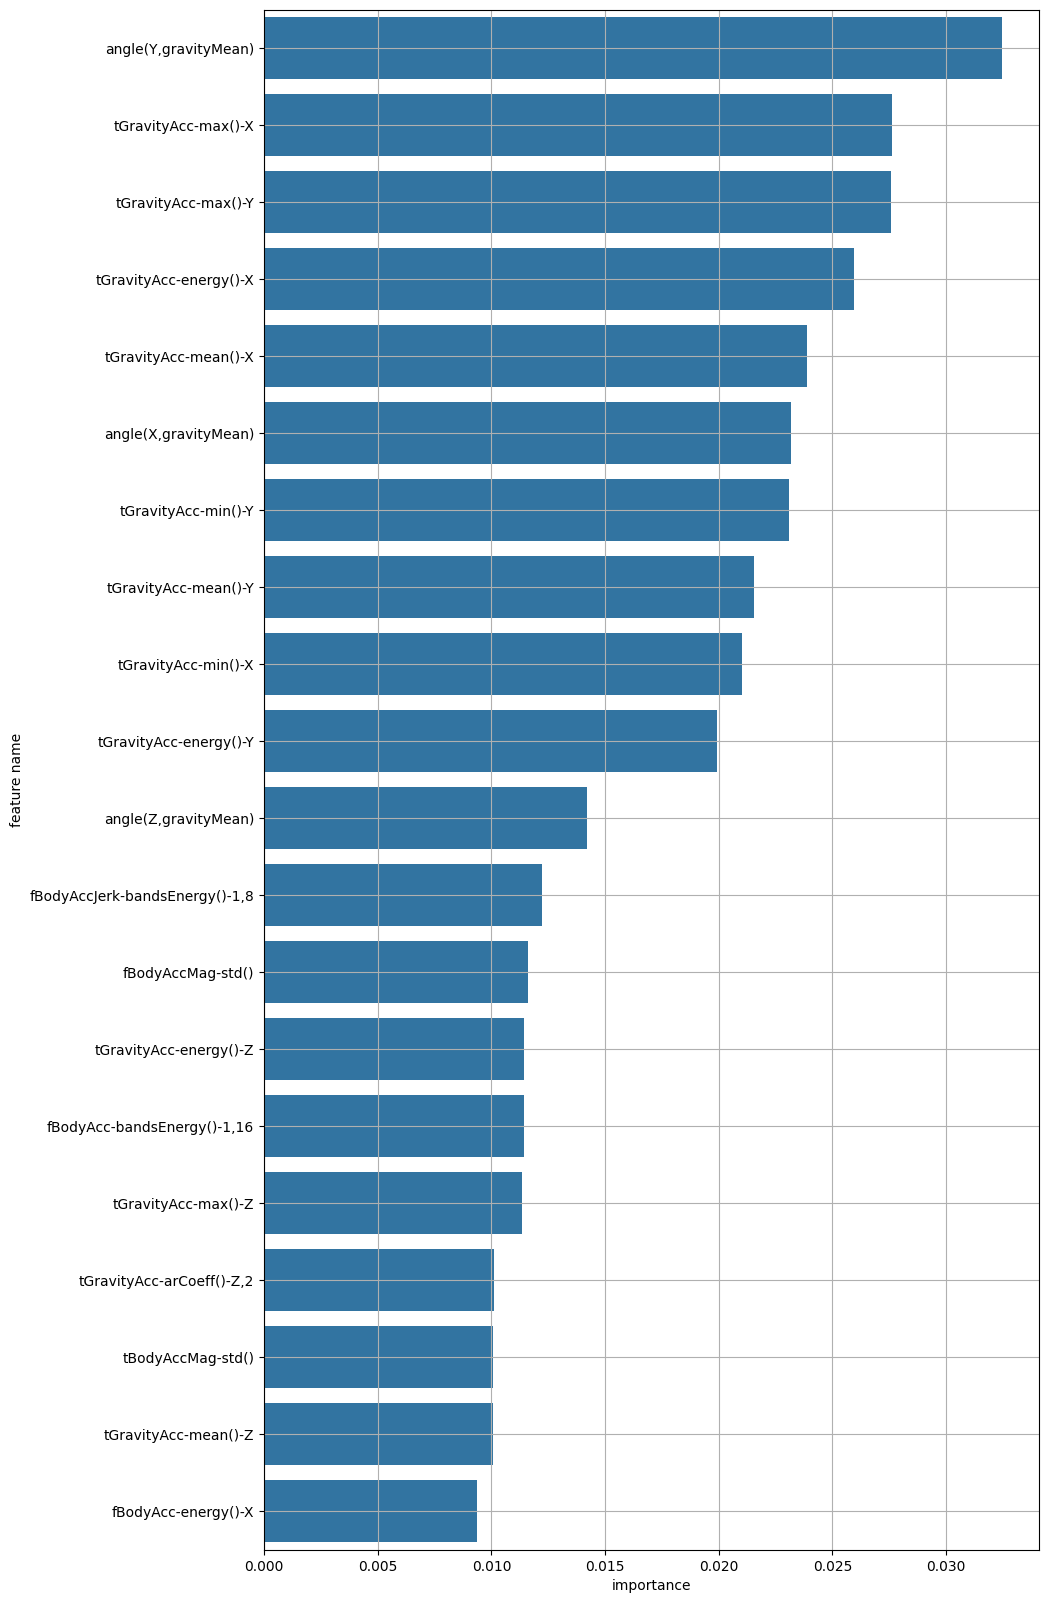

In [205]:
# 변수 중요도 계산 및 시각화 함수 사용
fi_df = plot_feature_importance(model_rf.feature_importances_, x_train.columns, result_only=False, topn=20)
fi_df

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [207]:
top5_feature = fi_df.head(5)['feature_name'].values
top5_feature

array(['angle(Y,gravityMean)', 'tGravityAcc-max()-X',
       'tGravityAcc-max()-Y', 'tGravityAcc-energy()-X',
       'tGravityAcc-mean()-X'], dtype=object)

In [209]:
bottom5_features = fi_df.tail(5)['feature_name'].values
bottom5_features

array(['tGravityAcc-max()-Z', 'tGravityAcc-arCoeff()-Z,2',
       'tBodyAccMag-std()', 'tGravityAcc-mean()-Z', 'fBodyAcc-energy()-X'],
      dtype=object)

#### 2) 상위 5개 변수에 대한 분석

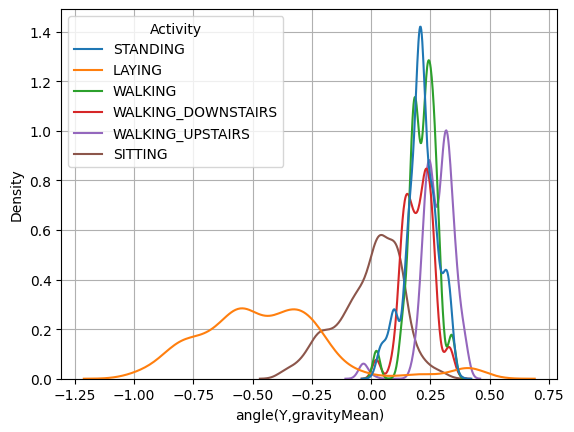

In [212]:
# angle(Y,gravityMean)
feature = 'angle(Y,gravityMean)'
target = 'Activity'
sns.kdeplot(x = feature, data = data, hue = target)
plt.grid()
plt.show()

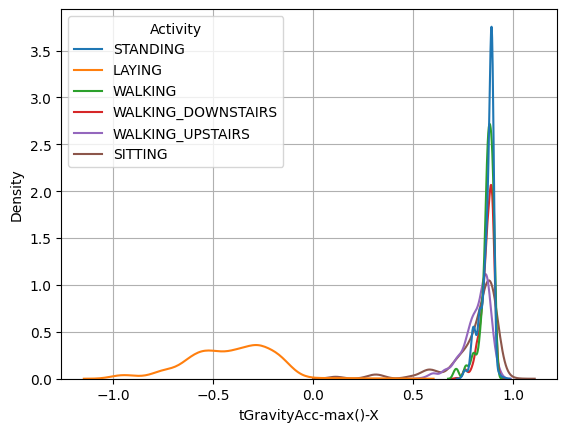

In [214]:
# tGravityAcc-max()-X
feature = 'tGravityAcc-max()-X'
target = 'Activity'
sns.kdeplot(x = feature, data = data, hue = target)
plt.grid()
plt.show()

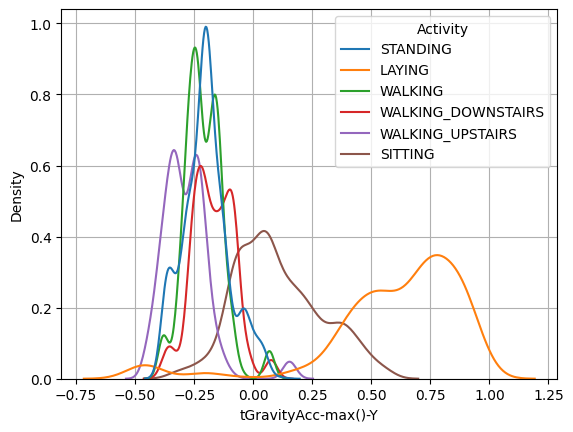

In [216]:
# tGravityAcc-max()-Y
feature = 'tGravityAcc-max()-Y'
target = 'Activity'
sns.kdeplot(x = feature, data = data, hue = target)
plt.grid()
plt.show()

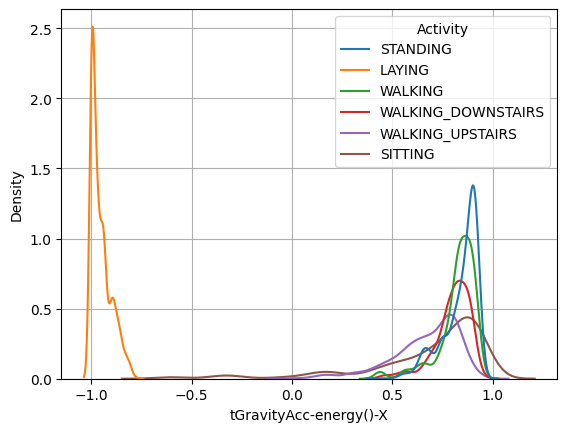

In [218]:
# tGravityAcc-energy()-X
feature = 'tGravityAcc-energy()-X'
target = 'Activity'
sns.kdeplot(x = feature, data = data, hue = target)
plt.grid()
plt.show()

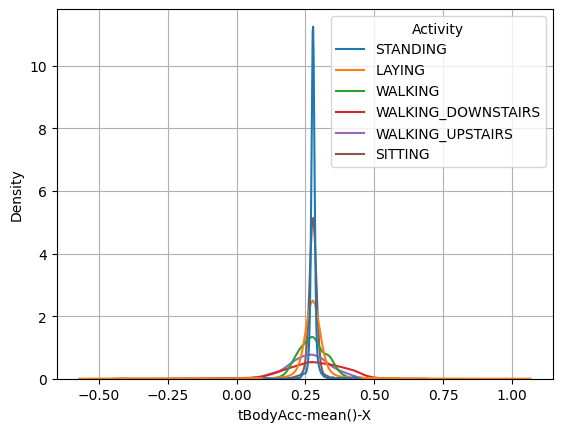

In [220]:
# tBodyAcc-mean()-X
feature = 'tBodyAcc-mean()-X'
target = 'Activity'
sns.kdeplot(x = feature, data = data, hue = target)
plt.grid()
plt.show()

#### 3) 하위 5개 변수에 대한 분석

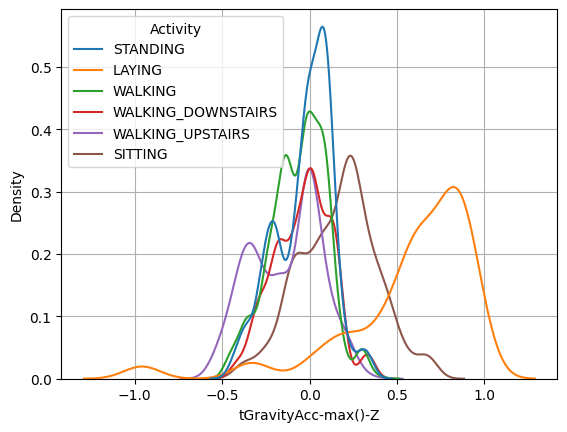

In [222]:
# tGravityAcc-max()-Z
feature = 'tGravityAcc-max()-Z'
target = 'Activity'
sns.kdeplot(x = feature, data = data, hue = target)
plt.grid()
plt.show()

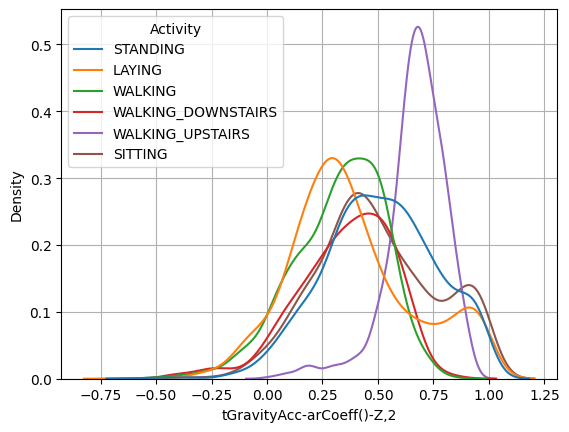

In [224]:
# tGravityAcc-arCoeff()-Z,2
feature = 'tGravityAcc-arCoeff()-Z,2'
target = 'Activity'
sns.kdeplot(x = feature, data = data, hue = target)
plt.grid()
plt.show()

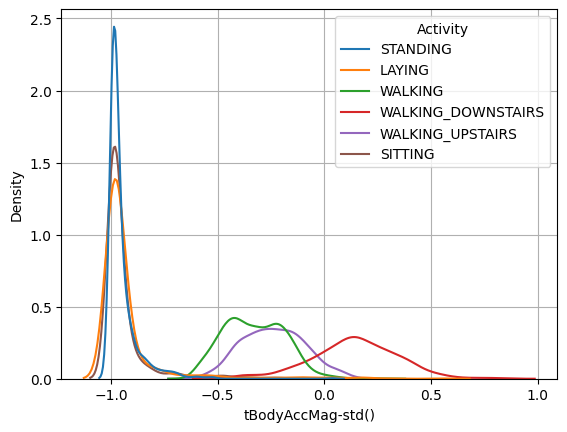

In [226]:
# tBodyAccMag-std()
feature = 'tBodyAccMag-std()'
target = 'Activity'
sns.kdeplot(x = feature, data = data, hue = target)
plt.grid()
plt.show()

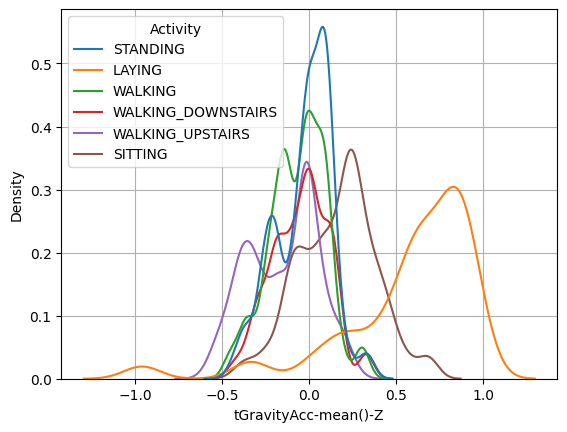

In [228]:
# tGravityAcc-mean()-Z
feature = 'tGravityAcc-mean()-Z'
target = 'Activity'
sns.kdeplot(x = feature, data = data, hue = target)
plt.grid()
plt.show()

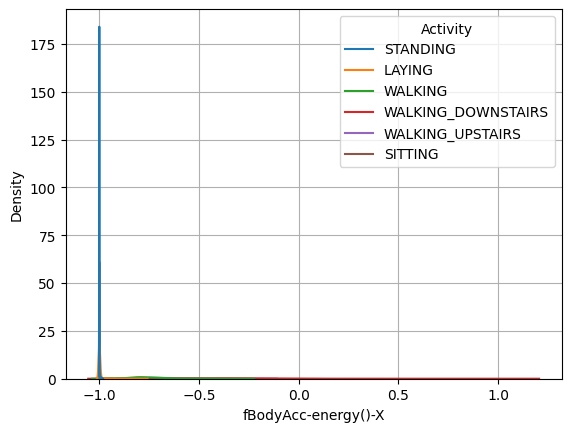

In [230]:
# fBodyAcc-energy()-X
feature = 'fBodyAcc-energy()-X'
target = 'Activity'
sns.kdeplot(x = feature, data = data, hue = target)
plt.grid()
plt.show()

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.

#### 1) is_dynamic 추가

In [233]:
data['is_dynamic'] = np.where(data['Activity'].isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']), 1, 0)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1


#### 2) 기본모델 생성

In [236]:
x = data.drop(columns=['Activity', 'is_dynamic'])
y = data['is_dynamic']

# train, validation 분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=1)

In [238]:
model_rf_dynamic = RandomForestClassifier(random_state=1)
model_rf_dynamic.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

#### 3) 변수중요도 상위 5개 분석

,feature_name,feature_importance
0,fBodyAccJerk-mad()-X,0.069960
1,tBodyAccJerk-energy()-X,0.050077
2,tBodyAccJerk-mad()-X,0.049970
3,"fBodyAccJerk-bandsEnergy()-1,24",0.049961
4,"fBodyAccJerk-bandsEnergy()-1,16",0.040332


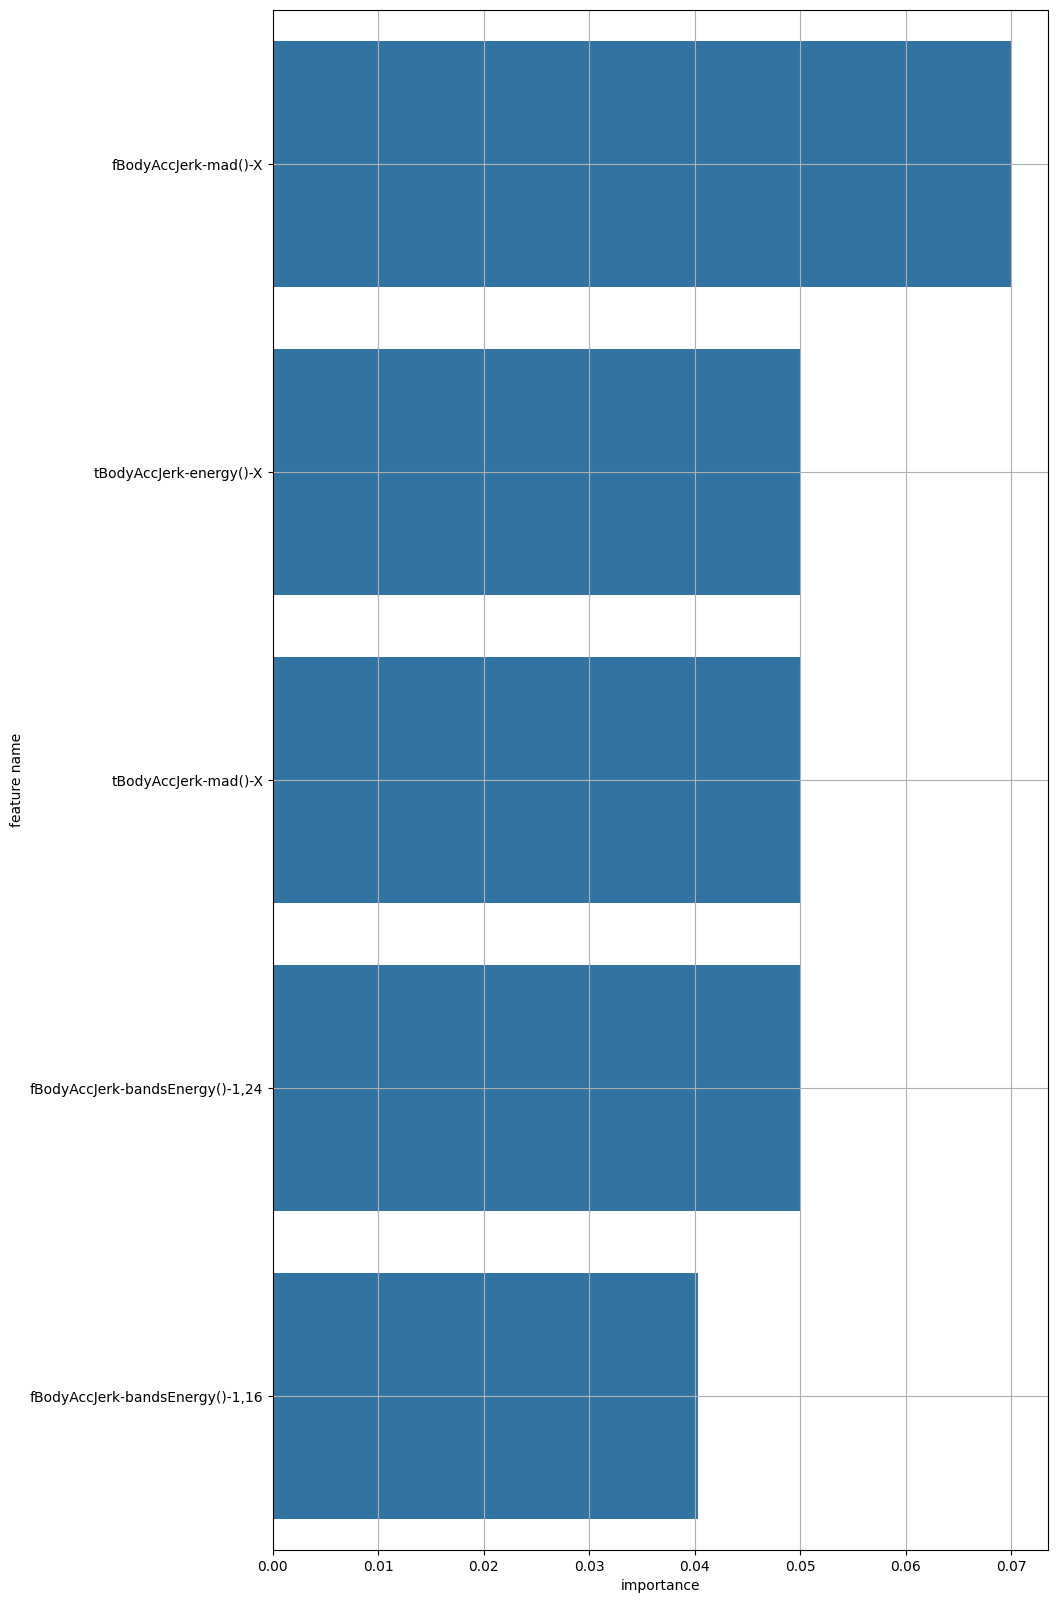

In [242]:
top5_dynamic_features = plot_feature_importance(model_rf_dynamic.feature_importances_, x_train.columns, result_only=False, topn=5)
top5_dynamic_features

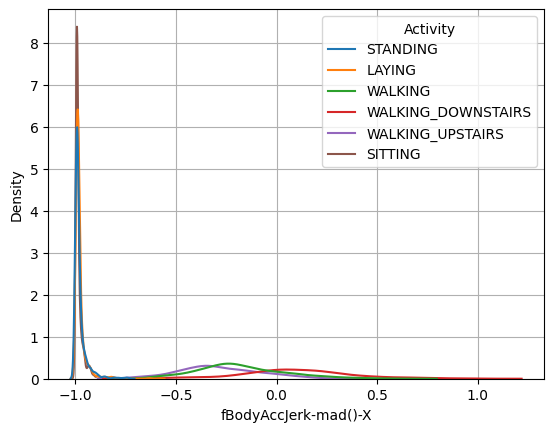

In [246]:
# fBodyAccJerk-mad()-X
feature = 'fBodyAccJerk-mad()-X'
target = 'Activity'
sns.kdeplot(x = feature, data = data, hue = target)
plt.grid()
plt.show()

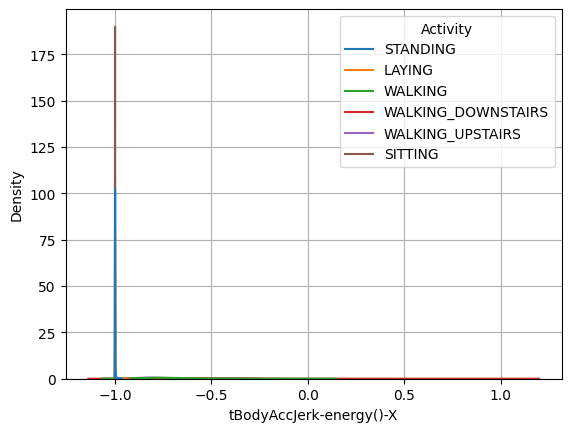

In [248]:
# tBodyAccJerk-energy()-X
feature = 'tBodyAccJerk-energy()-X'
target = 'Activity'
sns.kdeplot(x = feature, data = data, hue = target)
plt.grid()
plt.show()

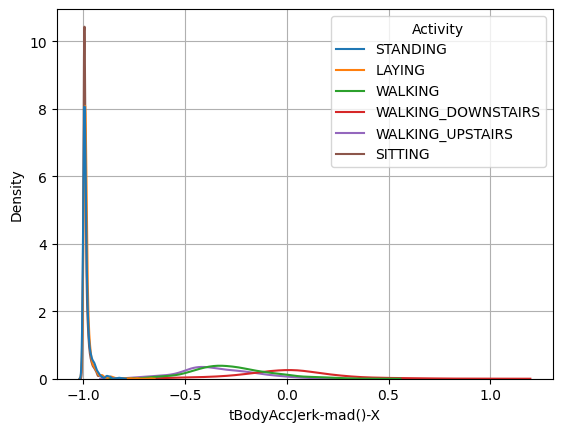

In [250]:
# tBodyAccJerk-mad()-X
feature = 'tBodyAccJerk-mad()-X'
target = 'Activity'
sns.kdeplot(x = feature, data = data, hue = target)
plt.grid()
plt.show()

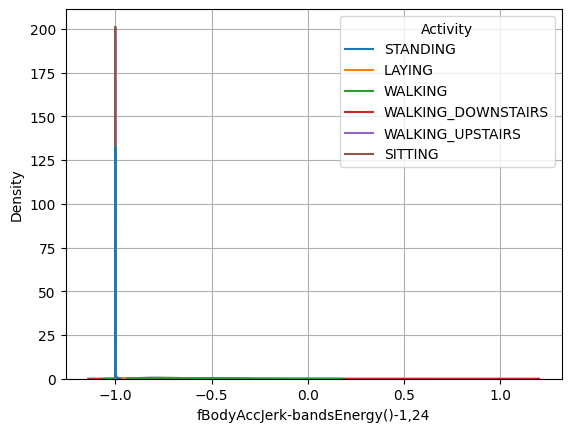

In [252]:
# fBodyAccJerk-bandsEnergy()-1,24
feature = 'fBodyAccJerk-bandsEnergy()-1,24'
target = 'Activity'
sns.kdeplot(x = feature, data = data, hue = target)
plt.grid()
plt.show()

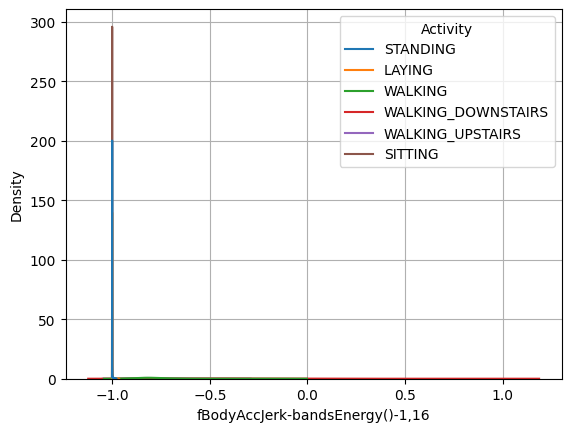

In [254]:
# fBodyAccJerk-bandsEnergy()-1,16
feature = 'fBodyAccJerk-bandsEnergy()-1,16'
target = 'Activity'
sns.kdeplot(x = feature, data = data, hue = target)
plt.grid()
plt.show()